In [147]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [2]:
events = pd.read_csv("./filestore/events/fact_events.csv").drop('Unnamed: 0', axis=1)

In [3]:
events.head()

,description,duration,headcount,event_id,maybe_rsvp_count,name,rating,rsvp_limit,status,time,updated,utc_offset,venue_id,visibility,waitlist_count,yes_rsvp_count
0,These meetups are very informal. I won't be st...,9000000.0,12,147478282,0,PyLadies Dublin Inaugural meetup - bring laptop!,NaN,NaN,past,1384799400000,1384853013000,0,16176442,public,0,22
1,"Our second meetup will be at Engine Yard, a bi...",NaN,0,152107272,0,Second PyLadies Dublin Meetup - Let's get coding!,NaN,NaN,past,1387218600000,1387230236000,0,13054852,public,0,12
2,Happy New Year! Hope you all had a good Christ...,10800000.0,0,159368332,0,Our first PyLadies Dublin meetup of 2014,NaN,NaN,past,1390240800000,1390470097000,0,17757332,public,0,11
3,Bring your laptops along. If you want some foo...,10800000.0,0,162851382,0,PyLadies Dublin Feb meetup,NaN,NaN,past,1392660000000,1392672314000,0,18096492,public,0,9
4,!!!CHANGE OF VENUE UPDATE!!! &gt;&gt; More inf...,10800000.0,0,166955082,0,PyLadies Dublin Meetup,NaN,NaN,past,1395165600000,1395219566000,0,18950322,public,0,11


In [4]:
events.dtypes

description          object
duration            float64
headcount             int64
event_id             object
maybe_rsvp_count      int64
name                 object
rating              float64
rsvp_limit          float64
status               object
time                  int64
updated               int64
utc_offset            int64
venue_id              int64
visibility           object
waitlist_count        int64
yes_rsvp_count        int64
dtype: object

# Let's look at the event descriptions

In [5]:
desc = events['description'].tolist()

In [6]:
desc

["These meetups are very informal. I won't be structuring until we get a feel on what we want/like to do. It all depends on who shows up. :-) So bring your laptop and please have Python installed, and we will do a quick introduction and get stuck in why we use Python, and start from there. They have free wi-fi (via bitbuzz) but that means we have to log in every 30 minutes. And we will be upstairs.",
 "Our second meetup will be at Engine Yard, a big thanks to Eamon and Jonathan for helping us out. So a few things:- • The meetup will be from 6:30PM to 9PM. •\xa0It's free to attend. • Bring your laptop. • If you have an idea and/or project, problems, bring them along. • We will be running through what source control is about, and for those who haven't set up their github account, please do so and email [masked] you username so I can add you to PyLadies Dublin github team. • Guys are welcome as well. :-D Venue thanks to Engine Yard:  Food thanks to Python Ireland: ",
 'Happy New Year! Hop

In [7]:
desc[4]

"!!!CHANGE OF VENUE UPDATE!!! &gt;&gt; More info on how to get there:&lt;&lt; • This is the building (google street view):\xa0http://bit.ly/Nr5DVk • Lab is in the annexe building – 1st\xa0floor keep right – through the double doors and its on the right A115 •\xa0Ask the porter in the lobby when you get here – its in the newer building beside the one in the photo…where the canteen is. AGENDA •\xa0Make sure those who want to work on PyLadies Dublin projects are on its github working group. •\xa0PyLadies Dublin first project will be the website. So we will be working on the Initial designs on PyLadies Dublin website. •\xa0Then decide who wants to work on what (you don't have to be committed to this, you can change to work on different section). •\xa0People can also work on personal projects, and others can also join in to help. • If you want to learn Python, come along, we have plenty of Pythonistas to help you. • Since venue change, not bringing tea/instant coffee, and I'm not sure about

## Cleaning up the description

### Punctuation and emojis
There are some emoji characters and unwanted punctuation

In [8]:
def find_unwanted_chars(s):
    pattern = r"[^a-zA-Z0-9\s.\-/':!?&@€$_+Éáéóć%]"
    return set(re.findall(pattern, s))

In [9]:
unwanted = set(char for e in desc for char in find_unwanted_chars(e))

In [10]:
clean_punct = []
for sent in desc:
    for punct in unwanted:
        sent = sent.replace(punct, "")
    clean_punct.append(sent)

In [11]:
clean_punct

["These meetups are very informal. I won't be structuring until we get a feel on what we want/like to do. It all depends on who shows up. :- So bring your laptop and please have Python installed and we will do a quick introduction and get stuck in why we use Python and start from there. They have free wi-fi via bitbuzz but that means we have to log in every 30 minutes. And we will be upstairs.",
 "Our second meetup will be at Engine Yard a big thanks to Eamon and Jonathan for helping us out. So a few things:-  The meetup will be from 6:30PM to 9PM. \xa0It's free to attend.  Bring your laptop.  If you have an idea and/or project problems bring them along.  We will be running through what source control is about and for those who haven't set up their github account please do so and email masked you username so I can add you to PyLadies Dublin github team.  Guys are welcome as well. :-D Venue thanks to Engine Yard:  Food thanks to Python Ireland: ",
 "Happy New Year! Hope you all had a go

### Unicode, URLS, smiley faces

In [12]:
special_dict = {
    'smile' : r'[:;=]-[)D]?',
    'uni' : r'\xa0',
    'dupe_space' : r'\s{2,}|\s\Z',
    'uls_chars' :  r'(?:&[gla][tm]p?)+',
    'url' : r'(?:https|ftp|file)://\S+'
}


def remove_special(s):
    for k, regex in special_dict.items():
        s = re.sub(regex, "", s)
    return s

In [13]:
clean_special = [remove_special(s).lower() for s in clean_punct]

In [17]:
clean_special[:3]

["these meetups are very informal. i won't be structuring until we get a feel on what we want/like to do. it all depends on who shows up.so bring your laptop and please have python installed and we will do a quick introduction and get stuck in why we use python and start from there. they have free wi-fi via bitbuzz but that means we have to log in every 30 minutes. and we will be upstairs.",
 "our second meetup will be at engine yard a big thanks to eamon and jonathan for helping us out. so a few thingsthe meetup will be from 6:30pm to 9pm. it's free to attend.bring your laptop.if you have an idea and/or project problems bring them along.we will be running through what source control is about and for those who haven't set up their github account please do so and email masked you username so i can add you to pyladies dublin github team.guys are welcome as well.venue thanks to engine yard:food thanks to python ireland:",
 "happy new year! hope you all had a good christmas break? whoop wh

## Tokenizing and removing stop words

In [60]:
en_stopwords = stopwords.words('english')
extra_stopwords = ['python', 'speaker', 'speakers', 'dublin', 'ireland', 'pyladies', \
    'talk', 'talks', 'irish']
en_stopwords = en_stopwords + extra_stopwords

Vectorizer splits our documents into a distribution of words.
 
X is a term document matrix, where each document is a column and words are rows. The value associated to each cell is the TF-IDF

In [150]:
vectorizer = TfidfVectorizer(stop_words = set(en_stopwords))
X = vectorizer.fit_transform(clean_special)

The vectorizer we got above is used as input for LDA or NMF to build the model

# Exploring K-means Clustering

In [106]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist 

Since we don't have an idea of how many topics can there be, let's use the silhouette score as a measure of how many clusters we should have.

In [143]:
clusters = range(1,30)
distortions = []
silhouette_coeffs = []

for k in clusters:
    km = KMeans(n_clusters=true_k, init='k-means++', max_iter=300, n_init=10,verbose=0)
    km.fit(X)
    
    distortions.append(km.inertia_)
    silhouette_coeffs.append(metrics.silhouette_score(X, km.labels_))

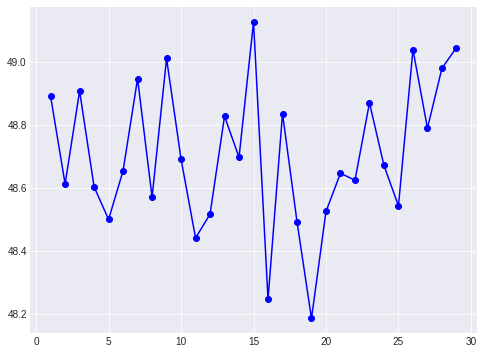

In [144]:
plt.style.use('seaborn-darkgrid')
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(clusters, distortions, marker='o', color='b')
ax.title('Elbow method for k-means')
plt.show()

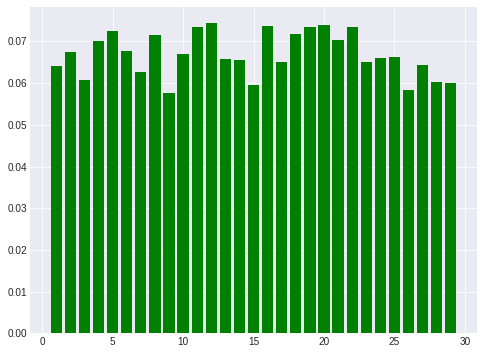

In [145]:
plt.style.use('seaborn-darkgrid')
fig, ax = plt.subplots(figsize=(8,6))

ax.bar(x=clusters, height=silhouette_coeffs, color='g')
plt.show()

It seems that the preprocessing done was not enough and the k-means algorithm is being too sensitive to the data. It could be worthwhile trying to extract the event descriptions manually as there are only 70 ish events...

Below a sample clustering for k=15, doesn't seem good.

In [98]:
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

for i in range(true_k):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Cluster 0: products intercom marketing communication way every customer customers operating apps
Cluster 1: workshop 00 labs dogpatch django 30 please 18 using get
Cluster 2: notes things ourmailing suitable discussions october sharing well listfor join
Cluster 3: graphite metricfire hosted data ofmetric servers sourcemetric billionper points amounts
Cluster 4: tech 00pm summit spot women meet workdays discussion talented 30pm
Cluster 5: projects qualtrics pytorch food rsvp month meetups please short cannot
Cluster 6: ics ict society parking available outside skills building notes computer
Cluster 7: prizes lala quiz group round table code team women night
Cluster 8: udemy lia patterns 00 19 design paradigmatic also learning multi
Cluster 9: ai landscape grad patch facebook projects 30 cities stella submitting
Cluster 10: meetup details interested indeed traffic speaking please october call forget
Cluster 11: max micropython part workshop provided 35 demonware need vizard devices
Clust

# Exploring LDA

In [149]:
count_vector = CountVectorizer(stop_words = set(en_stopwords))
word_counts = count_vector.fit_transform(clean_special)

In [162]:
count_df = pd.DataFrame(word_counts.toarray(), columns= count_vector.get_feature_names())

In [192]:
agg_counts = pd.DataFrame({
    'word' : count_vector.get_feature_names(),
    'count' : count_df.T.apply(np.sum, axis=1)
}).reset_index(drop=True)

In [195]:
agg_counts.sort_values('count', ascending=False).iloc[:50,:]

,index,count
333,bring,97
930,free,84
1703,please,84
1812,questions,70
0,00,68
1436,meetup,66
817,event,63
1272,laptop,63
904,food,61
1768,projects,57


From looking at the counts above, the text quality doesn't look good. I will apply some manual cleansing to the description to get a more accurate representation of the Event descriptions